In [2]:
!pip install emoji
!pip install mawo_pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 3.4 MB/s eta 0:00:00


In [143]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from collections import Counter

import emoji
import nltk
from nltk.corpus import stopwords
from mawo_pymorphy3 import create_analyzer

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, make_scorer
from sklearn.pipeline import Pipeline
import joblib

# EDA

## Загрузка датасета

Формат датасета:
- text — текст отзыва
- label — числовая метка тональности (0, 1, 2)
- src — источник данных (например, rureviews)

In [80]:
# Для Colab
import gdown

file_id = "1e-sTvQRZsx2dPjAvkjRSdbWDQ1ra1zAJ"
url = f'https://drive.google.com/uc?id={file_id}'
output = 'file.zip'

gdown.download(url, output, quiet=False)

import zipfile
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('.')
    print("Файлы распакованы!")

import os
print("Содержимое папки:")
print(os.listdir('.'))

Downloading...
From (original): https://drive.google.com/uc?id=1e-sTvQRZsx2dPjAvkjRSdbWDQ1ra1zAJ
From (redirected): https://drive.google.com/uc?id=1e-sTvQRZsx2dPjAvkjRSdbWDQ1ra1zAJ&confirm=t&uuid=d42d77d8-67d7-4701-995e-532243d14d3b
To: /content/file.zip
100%|██████████| 76.6M/76.6M [00:00<00:00, 244MB/s]


Файлы распакованы!
Содержимое папки:
['.config', 'ТОНАЛЬНОСТЬ', 'train_cleaned_before_stopwords.csv', 'train_cleaned_stopwords_lemm.csv', 'train_cleaned_stopwords_before_lemm.csv', 'file.zip', 'top_emojis.json', 'sample_data']


In [81]:
df = pd.read_csv('ТОНАЛЬНОСТЬ/train.csv')
test = pd.read_csv('ТОНАЛЬНОСТЬ/test.csv')
df.head()

,ID,text,src,label
0,26739,smaller than in description.,rureviews,0
1,198426,Слева от меня Алексей Ильмухин. Путешественник...,rusentiment,1
2,172615,"Ребёнок в садик отходил год, из них пол года п...",geo,2
3,246532,Замерзла на -15,perekrestok,2
4,209852,"Как всегда, название не соответствует истинном...",kinopoisk,0


In [ ]:
# Для локального запуска
# DATA_DIR = Path(os.getcwd()) / 'data'
# TRAIN_DATASET_PATH = DATA_DIR / 'train.csv'
# TEST_DATASET_PATH = DATA_DIR / 'test.csv'

# df = pd.read_csv(TRAIN_DATASET_PATH)
# test = pd.read_csv(TEST_DATASET_PATH)
# df.head()

Проверим пропуски.

In [71]:
print(f'Всего строк: {len(df)}')
df.isnull().sum()

Всего строк: 232366


,0
ID,0
text,0
src,0
label,0


## Анализ классов и источников

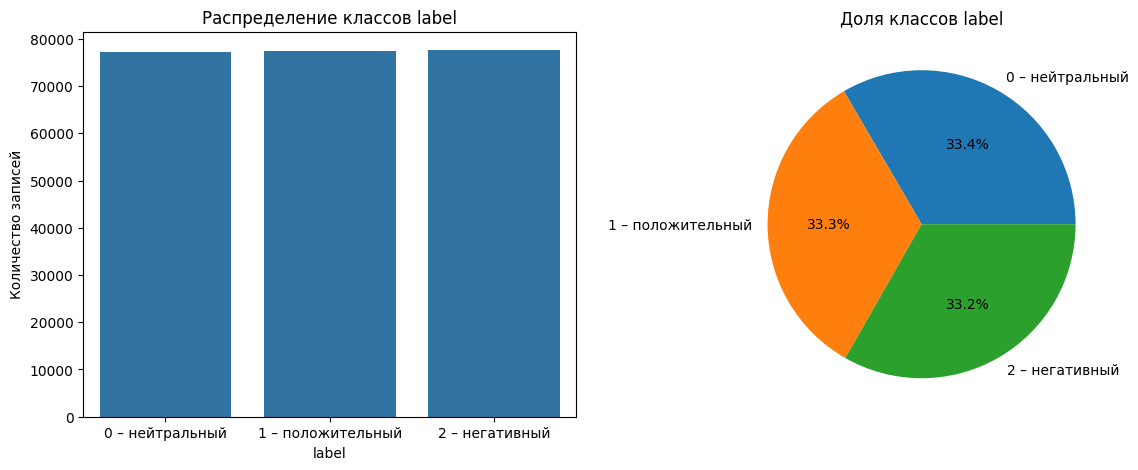

In [37]:
# Анализ label
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(data=df, x='label', ax=ax1)
ax1.set_title('Распределение классов label')
ax1.set_xlabel('label')
ax1.set_ylabel('Количество записей')
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['0 – нейтральный', '1 – положительный', '2 – негативный'])

ax2.pie(df['label'].value_counts(normalize=True) * 100, autopct='%.1f%%', labels=['0 – нейтральный', '1 – положительный', '2 – негативный'])
ax2.set_title('Доля классов label')

plt.show()

/tmp/ipython-input-1118674685.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(src_counts.index, rotation=45, ha='right')


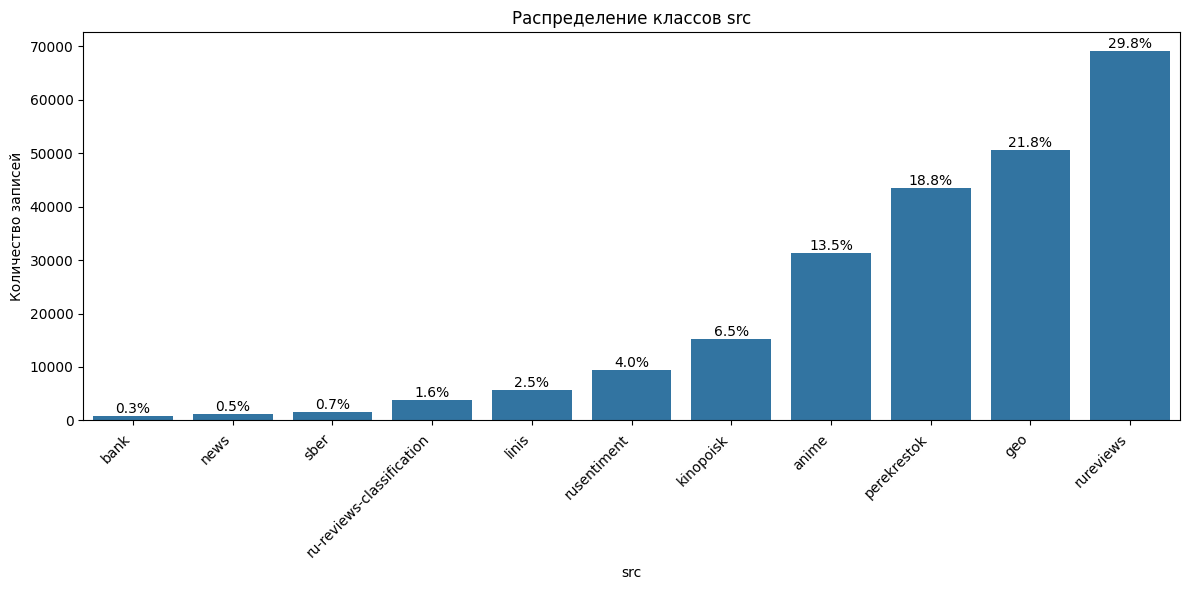

In [38]:
# Анализ src
plt.figure(figsize=(12, 6))
ax = plt.gca()

src_counts = df['src'].value_counts().sort_values()

bars = sns.countplot(data=df, x='src', ax=ax, order=src_counts.index)
ax.set_title('Распределение классов src')
ax.set_xlabel('src')
ax.set_ylabel('Количество записей')
ax.set_xticklabels(src_counts.index, rotation=45, ha='right')
ax.tick_params(axis='x', which='major', pad=5)

total = len(df)
for i, (bar, count) in enumerate(zip(bars.patches, src_counts.values)):
    height = bar.get_height()
    percentage = (count / total) * 100
    ax.text(bar.get_x() + bar.get_width() / 2., height + 0.1,
            f'{percentage:.1f}%',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

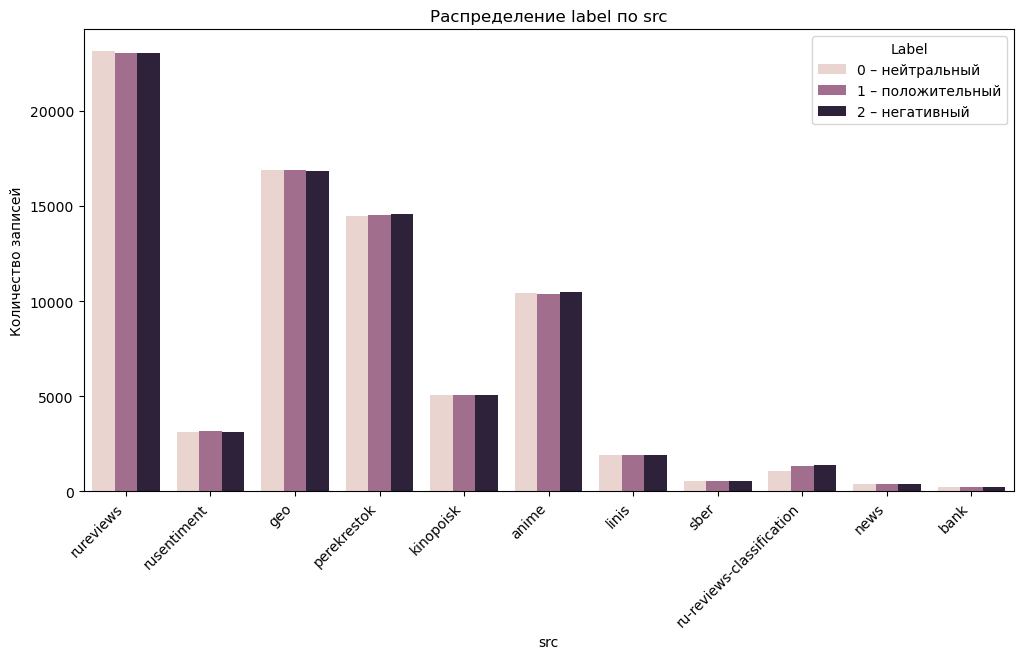

In [ ]:
# Анализ распределения label по src
plt.figure(figsize=(12, 6))

# Создаем группированную гистограмму
sns.countplot(data=df, x='src', hue='label')
plt.title('Распределение label по src')
plt.xlabel('src')
plt.ylabel('Количество записей')
plt.legend(title='Label', labels=['0 – нейтральный', '1 – положительный', '2 – негативный'])
plt.xticks(rotation=45, ha='right')

plt.show()

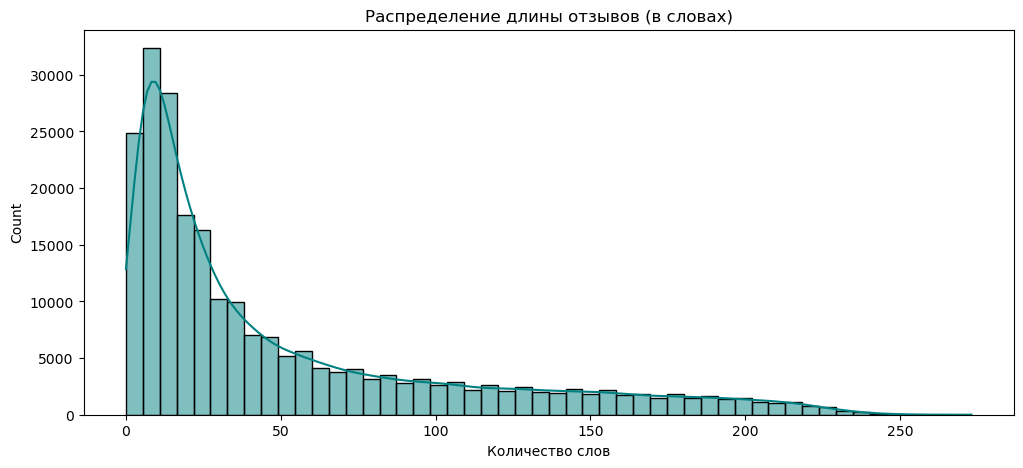

Средняя длина: 51.2 слов
Максимальная длина: 273.0 слов
95-й перцентиль: 180.0 слов
99-й перцентиль: 218.0 слов


In [ ]:
# Длина тектов в словах
# Пригодится для BERT
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))
sns.histplot(df['word_count'], bins=50, kde=True, color='teal')
plt.title('Распределение длины отзывов (в словах)')
plt.xlabel('Количество слов')
plt.show()

print(f"Средняя длина: {df['word_count'].mean():.1f} слов")
print(f"Максимальная длина: {df['word_count'].max():.1f} слов")
print(f"95-й перцентиль: {df['word_count'].quantile(0.95):.1f} слов")
print(f"99-й перцентиль: {df['word_count'].quantile(0.99):.1f} слов")

In [ ]:
# Поиск дубликатов
duplicates = df.duplicated(subset=['text', 'label'], keep='first').sum()
print(f"Дубликаты (текст + лейбл): {duplicates}")

# Поиск противоречий label в дубликатах
text_label_counts = df.groupby('text')['label'].nunique()
conflicting_texts = text_label_counts[text_label_counts > 1]
print(f"Противоречия label в дубликатах: {len(conflicting_texts)}")

examples = conflicting_texts.head(3).index.tolist()
bad_df = df[df['text'].isin(examples)].sort_values('text')
display(bad_df[['text', 'label', 'src']])

Дубликаты (текст + лейбл): 21
Противоречия label в дубликатах: 19


,text,label,src
86966,Все понравилось,0,perekrestok
139423,Все понравилось,1,rureviews
168664,Маленькая,0,perekrestok
184633,Маленькая,2,rureviews
150660,Маленький размер,2,rureviews
196407,Маленький размер,0,perekrestok


Итого:
- Дисбаланса классов по label нет.
- Разное количество строк с различными src.
- Дубликатов и противоречий очень мало относительно всего датасета. Их можно просто удалить.

In [84]:
# Из дубликатов удаляем только один
df = df.drop_duplicates(subset=['text', 'label'], keep='first')

# Противоречия удаляем все
text_label_counts_after_drop = df.groupby('text')['label'].nunique()
conflicting_texts_to_drop = text_label_counts_after_drop[text_label_counts_after_drop > 1].index
df = df[~df['text'].isin(conflicting_texts_to_drop)]

print(f'Количество строк в датасете: {len(df)}')

Количество строк в датасете: 232307


# Preprocessing

## Очистка текста

Некоторые отзывы содержат эмодзи. Какие-то из них несут информацию об эмоциях пользователя, какие-то нет. Попробуем их преобразовать.

In [85]:
# Поиск эмодзи
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # эмоции
    "\U0001F300-\U0001F5FF"  # символы и пиктограммы
    "\U0001F680-\U0001F6FF"  # транспорт и карты
    "\U0001F1E0-\U0001F1FF"  # флаги
    "\U00002702-\U000027B0"
    "\U000024C2-\U0001F251"
    "\U0001F900-\U0001F9FF"
    "]+",
    flags=re.UNICODE
)

def extract_all_emojis(text):
    if pd.isna(text):
        return []
    return emoji_pattern.findall(str(text))

all_emojis = []

for text in df['text'].dropna():
    emojis = extract_all_emojis(text)
    all_emojis.extend(emojis)

# Подсчитываем частоту каждого эмодзи
emoji_counter = Counter(all_emojis)

emoji_df = pd.DataFrame({
    'emoji': list(emoji_counter.keys()),
    'count': list(emoji_counter.values()),
    'frequency_percent': [count/len(all_emojis)*100 for count in emoji_counter.values()]
})

emoji_df = emoji_df.sort_values('count', ascending=False).reset_index(drop=True)
emoji_df['rank'] = range(1, len(emoji_df) + 1)

print(f'Всего эмодзи: {len(all_emojis)}')
print(f'Уникальных эмодзи: {len(emoji_df)}')
print('Топ-30 самых частых эмодзи:')

emoji_df.head(30)

Всего эмодзи: 10756
Уникальных эмодзи: 1787
Топ-30 самых частых эмодзи:


,emoji,count,frequency_percent,rank
0,👍,776,7.214578,1
1,♀️,409,3.802529,2
2,❤️,276,2.566010,3
3,😂,217,2.017479,4
4,😊,210,1.952399,5
5,🤦,198,1.840833,6
6,⠀,188,1.747862,7
7,😁,180,1.673485,8
8,🤷,175,1.626999,9
9,👍🏻,152,1.413165,10


In [86]:
def extract_emojis(text):
    return [ch for ch in text if ch in emoji.EMOJI_DATA]

all_emojis = []
for txt in df['text']:
    all_emojis.extend(extract_emojis(str(txt)))

emoji_counts = Counter(all_emojis)

# Топ-30 самых частотных
top_emojis = [e for e, c in emoji_counts.most_common(30)]

# Преобразует топ-30 эмодзи в текстовые теги, остальные заменяет на EMOJI_OTHER
def normalize_emoji(text, top_emojis_set=set(top_emojis)):
    def replace_char(ch):
        if ch in emoji.EMOJI_DATA:
            if ch in top_emojis_set:
                desc = emoji.demojize(ch).strip(":").upper()
                return f"EMOJI_{desc}"
            else:
                return "EMOJI_OTHER"
        else:
            return ch
    new_text = "".join(replace_char(ch) for ch in text)
    return new_text

df['text'] = df['text'].astype(str).apply(normalize_emoji)

In [87]:
import json

# Сохраняем в JSON файл
with open("top_emojis.json", "w", encoding="utf-8") as f:
    json.dump(top_emojis, f, ensure_ascii=False)

print("Топ-30 эмодзи сохранены в top_emojis.json")

Топ-30 эмодзи сохранены в top_emojis.json


In [51]:
from google.colab import files

files.download("top_emojis.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Далее очищаем цифры, спецсимволы, двойные пробелы.

In [88]:
def clean_text(text):
    # Приводим к нижнему регистру
    text = text.lower()
    # Убираем HTML-теги
    text = re.sub(r'<[^>]+>', ' ', text)
    # Убираем лишние символы (кроме букв и EMOJI_XXX)
    text = re.sub(r'[^a-zа-я0-9_ | ё]', ' ', text)
    # Убираем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].apply(clean_text)
df_before_stopwords = df.copy(deep=True)

In [52]:
# df.to_csv("train_cleaned_before_stopwords.csv", index=False)

## Токенизация + удаление стоп-слов

In [89]:
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

def tokenize_remove_stopwords(text):
    tokens = text.split()  # простая токенизация по пробелу
    tokens = [t for t in tokens if t not in russian_stopwords]
    return " ".join(tokens)

# сделаем 2 отдельных датасета: с и без удаления стоп-слов
# мы работаем с датасетом, в котором удалены стоп-слова
df_no_stop = df.copy(deep=True)
df['text'] = df['text'].apply(tokenize_remove_stopwords)
df_stop = df.copy(deep=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


При удалении стоп-слов появились пустые строки. Их достаточно мало, так что их можно удалить.

In [101]:
print(f'Всего пустых строк при удалении стоп-слов: {len(df_stop[df_stop["text"] == ""])}')
df_stop[df_stop['text'] == '']

Всего пустых строк при удалении стоп-слов: 147


,ID,text,src,label
1620,53620,,rureviews,1
4240,247556,,perekrestok,2
4507,195261,,rusentiment,0
6404,287410,,perekrestok,1
10433,192756,,rusentiment,0
...,...,...,...,...
217957,60482,,rureviews,2
220113,2928,,rureviews,0
220835,22564,,rureviews,0
222430,262390,,perekrestok,0


In [112]:
df_stop = df_stop[df_stop['text'] != '']

In [ ]:
# df_no_stop.to_csv("train_cleaned_no_stopwords_before_lemm.csv", index=False)
# df_stop.to_csv("train_cleaned_stopwords_before_lemm.csv", index=False)

## Лемматизация

In [57]:
from tqdm.auto import tqdm
tqdm.pandas()

analyzer = create_analyzer()

def lemmatize_text_mawo(text):
    tokens = text.split()
    lemmas = []
    for token in tokens:
        if token.startswith("EMOJI_"):
            lemmas.append(token)
        else:
            parsed = analyzer.parse(token)
            if parsed:
                lemmas.append(parsed[0].normal_form)
            else:
                lemmas.append(token)
    return " ".join(lemmas)

# Применяем с прогресс-баром
df['text'] = df['text'].progress_apply(lemmatize_text_mawo)

  0%|          | 0/232366 [00:00<?, ?it/s]

In [ ]:
# from google.colab import files

# df.to_csv("train_cleaned_stopwords_lemm.csv", index=False)
# files.download('train_cleaned_stopwords_lemm.csv')

# Обучение

Начнем с реализации бейзлайна TF-IDF + LogReg

In [62]:
# загрузим сохранившийся csv с лемматизированными текстами
!gdown --id 1sWDUYe3psCozYfqBhCGIT9IYS3bLcHPq

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1sWDUYe3psCozYfqBhCGIT9IYS3bLcHPq
From (redirected): https://drive.google.com/uc?id=1sWDUYe3psCozYfqBhCGIT9IYS3bLcHPq&confirm=t&uuid=376c3624-2039-4cb9-bf8a-f4640787cf8e
To: /content/train_cleaned_stopwords_lemm.csv
100% 117M/117M [00:00<00:00, 180MB/s]


In [114]:
df = pd.read_csv("train_cleaned_stopwords_lemm.csv")

# df = df[~df['text'].isnull()]
df[df['text'].isnull()]

,ID,text,src,label


In [140]:
# TD-IDF
X = df['text']
y = df['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [141]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=200000,
        ngram_range=(1,2),
        min_df=1,
        max_df=0.9,
        sublinear_tf=True,
        norm='l2'
    )),
    ('clf', LogisticRegression(
        solver='liblinear',
        max_iter=200,
        C=1,
        random_state=42
    ))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=200000,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('clf',
                 LogisticRegression(C=1, max_iter=200, random_state=42,
                                    solver='liblinear'))])

In [142]:
y_pred = pipeline.predict(X_val)
f1 = f1_score(y_val, y_pred, average='macro')
print(f"Macro-F1 на валидации: {f1:.4f}")
print(classification_report(y_val, y_pred))

Macro-F1 на валидации: 0.6943
              precision    recall  f1-score   support

           0       0.60      0.57      0.59     15487
           1       0.78      0.80      0.79     15450
           2       0.70      0.72      0.71     15507

    accuracy                           0.70     46444
   macro avg       0.69      0.70      0.69     46444
weighted avg       0.69      0.70      0.69     46444



In [144]:
# сохраняем модель для инференса
joblib.dump(pipeline, "final_logreg_tfidf_model.pkl")

['final_logreg_tfidf_model.pkl']

In [145]:
files.download("final_logreg_tfidf_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>